In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from itertools import combinations
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

%matplotlib inline

/home/mtmoncur/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
teams_abbr = {'- - -': '- - -', 'ANA': 'Angels', 'ARI': 'Diamondbacks', 
 'ATL': 'Braves', 'BAL': 'Orioles', 'BOS': 'Red Sox', 'CHC': 'Cubs', 
 'CHW': 'White Sox', 'CIN': 'Reds', 'CLE': 'Indians', 'COL': 'Rockies',
 'DET': 'Tigers', 'FLA': 'Marlins', 'HOU': 'Astros', 'KCR': 'Royals', 
 'LAA': 'Angels', 'LAD': 'Dodgers', 'MIA': 'Marlins', 'MIL': 'Brewers',
 'MIN': 'Twins', 'MON': 'Expos', 'NYM': 'Mets', 'NYY': 'Yankees',
 'OAK': 'Athletics', 'PHI': 'Phillies', 'PIT': 'Pirates', 'SDP': 'Padres',
 'SEA': 'Mariners', 'SFG': 'Giants', 'STL': 'Cardinals', 'TBD': 'Devil Rays', 
 'TBR': 'Rays', 'TEX': 'Rangers', 'TOR': 'Blue Jays', 'WSN': 'Nationals'}

In [3]:
#read in all data
sp = pd.read_csv('FanGraphs_Starters (2).csv')
rp = pd.read_csv('FanGraphs_Relievers (2).csv')
fd = pd.read_csv('FanGraphs_Fielders (2).csv')
bt = pd.read_csv('FanGraphs_Batting (2).csv')

a, b, c = len(sp),len(rp),len(fd)
print("""Number of starter pitchers:\t{}
Number of relief pitchers:\t{}
Number of fielders:\t\t{}
-------------------------------------
Total number of records:\t{}""".format(a, b, c, a+b+c))

#change abbreviation to full team name
fd.loc[[True]*len(fd),'Team'] = [teams_abbr[k] for k in fd.Team]



Number of starter pitchers:	2741
Number of relief pitchers:	1265
Number of fielders:		16122
-------------------------------------
Total number of records:	20128


In [4]:
print(bt.columns)
bt = bt[['Season', 'Name', 'Team', 'G', 'playerid']]
bt.sample(4)

Index(['Season', 'Name', 'Team', 'G', 'PA', 'HR', 'R', 'RBI', 'SB', 'BB%',
       'K%', 'ISO', 'BABIP', 'AVG', 'OBP', 'SLG', 'wOBA', 'wRC+', 'BsR', 'Off',
       'Def', 'WAR', 'playerid'],
      dtype='object')


,Season,Name,Team,G,playerid
1263,2016,Yasmani Grandal,Dodgers,126,11368
8331,2010,Tommy Manzella,Astros,83,3789
1902,2013,Luis Valbuena,Cubs,108,4969
3246,2016,Starlin Castro,Yankees,151,4579


In [5]:
print(rp.columns)
rp = rp[['Season', 'Name', 'Team', 'G', 'GS', 'IP', 'playerid']]
rp['Inn'] = rp['IP']
rp.drop('IP', axis=1, inplace=True)
rp.sample(4)

Index(['Season', 'Name', 'Team', 'W', 'L', 'SV', 'G', 'GS', 'IP', 'K/9',
       'BB/9', 'HR/9', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'ERA', 'FIP', 'xFIP',
       'WAR', 'playerid'],
      dtype='object')


,Season,Name,Team,G,GS,playerid,Inn
653,2016,Carlos Torres,Brewers,72,0,7624,82.1
309,2005,Neal Cotts,White Sox,69,0,1797,60.1
1186,2004,Al Levine,Tigers,65,0,20,70.2
702,2004,Carlos Almanzar,Rangers,67,0,308,72.2


In [6]:
sp.columns
sp = sp[['Season', 'Name', 'Team', 'G', 'GS', 'IP', 'playerid']]
sp['Inn'] = sp['IP']
sp.drop('IP', axis=1, inplace=True)
sp.sample(4)

,Season,Name,Team,G,GS,playerid,Inn
19,2013,Clayton Kershaw,Dodgers,33,33,2036,236.0
1933,2008,Shawn Hill,Nationals,12,12,1882,63.1
1397,2003,Nate Cornejo,Tigers,32,32,462,194.2
301,2009,Ricky Nolasco,Marlins,31,31,3830,185.0


In [7]:
print(fd.columns)
fd = fd[['Season', 'Name', 'Team', 'Pos', 'Inn', 'playerid']]
fd.sample(4)

Index(['Season', 'Name', 'Team', 'Pos', 'Inn', 'rSB', 'rGDP', 'rARM', 'rGFP',
       'rPM', 'DRS', 'BIZ', 'Plays', 'RZR', 'OOZ', 'CPP', 'RPP', 'TZL', 'FSR',
       'ARM', 'DPR', 'RngR', 'ErrR', 'UZR', 'UZR/150', 'Def', 'playerid'],
      dtype='object')


,Season,Name,Team,Pos,Inn,playerid
15568,2015,Ken Giles,Phillies,P,70.0,12910
13696,2008,Mark Lowe,Mariners,P,63.2,7416
11107,2009,Yuniesky Betancourt,Royals,SS,611.0,8585
10569,2005,Andy Marte,Braves,3B,130.2,3203


In [8]:
#create a 3 sets containing tuples of playerids with the season for each record
fd_season_id = set([tuple(row) for row in fd[['playerid','Season']].values])
rp_season_id = set([tuple(row) for row in rp[['playerid','Season']].values])
sp_season_id = set([tuple(row) for row in sp[['playerid','Season']].values])
bt_season_id = set([tuple(row) for row in bt[['playerid','Season']].values])

a, b, c, d = len(sp_season_id), len(rp_season_id), len(fd_season_id), len(bt_season_id)
total = set()
total.update(sp_season_id);total.update(rp_season_id);total.update(fd_season_id);total.update(bt_season_id)

print("Only counting players once per season.\n")
print("""Number of starter pitchers:\t{}
Number of relief pitchers:\t{}
Number of fielders:\t\t{}
Number of batters:\t\t{}
-------------------------------------
Total number of records:\t{}""".format(a, b, c, d, len(total)))


Only counting players once per season.

Number of starter pitchers:	2675
Number of relief pitchers:	1265
Number of fielders:		12253
Number of batters:		8348
-------------------------------------
Total number of records:	12445


In [9]:
print(len(bt_season_id.intersection(fd_season_id)))
print(len(bt_season_id.intersection(rp_season_id)))
print(len(bt_season_id.intersection(sp_season_id)))
print(len(rp_season_id.intersection(fd_season_id)))
print(len(rp_season_id.intersection(sp_season_id)))
print(len(sp_season_id.intersection(fd_season_id)))


8157
0
590
1264
3
2675


## Combine the pitchers first

The three below are the only ones that switched between starter and relief pitcher mid season.

In [10]:
name = 'Scot Shields'
print('sp', sp[sp.Name==name], end='\n')
print('rp', rp[rp.Name==name], end='\n')
print('fd', fd[fd.Name==name], end='\n')
print('bt', bt[bt.Name==name], end='\n\n')


name = 'Tim Wakefield'
print('sp', sp[sp.Name==name], end='\n')
print('rp', rp[rp.Name==name], end='\n')
print('fd', fd[fd.Name==name], end='\n')
print('bt', bt[bt.Name==name], end='\n\n')

name = 'Mike Montgomery'
print('sp', sp[sp.Name==name], end='\n')
print('rp', rp[rp.Name==name], end='\n')
print('fd', fd[fd.Name==name], end='\n')
print('bt', bt[bt.Name==name], end='\n\n')


sp       Season          Name    Team   G  GS  playerid   Inn
1371    2003  Scot Shields  Angels  13  13        35  78.2
rp      Season          Name    Team   G  GS  playerid    Inn
84     2005  Scot Shields  Angels  78   0        35   91.2
103    2004  Scot Shields  Angels  60   0        35  105.1
204    2006  Scot Shields  Angels  74   0        35   87.2
604    2003  Scot Shields  Angels  31   0        35   69.2
608    2007  Scot Shields  Angels  71   0        35   77.0
736    2008  Scot Shields  Angels  64   0        35   63.1
fd        Season          Name    Team Pos    Inn  playerid
12147    2003  Scot Shields  Angels   P  148.1        35
12406    2004  Scot Shields  Angels   P  105.1        35
12669    2005  Scot Shields  Angels   P   91.2        35
12932    2006  Scot Shields  Angels   P   87.2        35
13200    2007  Scot Shields  Angels   P   77.0        35
13458    2008  Scot Shields  Angels   P   63.1        35
bt Empty DataFrame
Columns: [Season, Name, Team, G, playerid]

In [11]:
temp = pd.merge(rp, sp, on=['playerid', 'Season'], how='outer')
print(temp.Name_x.count())
print(temp.Name_y.count())
print(temp.Season.count())
print(temp[(~temp.Name_x.isnull())*(~temp.Name_y.isnull())])

1265
2741
4003
     Season           Name_x   Team_x   G_x  GS_x  playerid  Inn_x  \
604    2003     Scot Shields   Angels  31.0   0.0        35   69.2   
783    2002    Tim Wakefield  Red Sox  30.0   0.0       219   65.1   
999    2017  Mike Montgomery     Cubs  30.0   0.0      4869   61.1   

              Name_y   Team_y   G_y  GS_y  Inn_y  
604     Scot Shields   Angels  13.0  13.0   78.2  
783    Tim Wakefield  Red Sox  15.0  15.0   98.0  
999  Mike Montgomery     Cubs  14.0  14.0   69.1  


/usr/local/lib/python3.5/dist-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [12]:
#solve these rare occurrences by hand
#Scot spent more time as a relief pitcher
sp['Pos'] = 'SP'
rp['Pos'] = 'RP'
sp.drop( sp[(sp['Name']=='Scot Shields')*(sp['Season']==2003)].index, inplace=True )

#Tim spent more time as a starter
rp.drop( rp[(rp['Name']=='Tim Wakefield')*(rp['Season']==2002)].index, inplace=True )

#Mike spent more time as a starter
rp.drop( rp[(sp['Name']=='Mike Montgomery')*(sp['Season']==2017)].index, inplace=True )


/usr/local/lib/python3.5/dist-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [13]:
pitchers = pd.concat([sp, rp], ignore_index=True)
pitchers.sort_values(by=['playerid', 'Season'])

,Season,Name,Team,G,GS,playerid,Inn,Pos
799,2002,Kevin Appier,Angels,32,32,3,188.1,SP
2509,2003,Kevin Appier,Angels,19,19,3,92.2,SP
2869,2010,Neftali Feliz,Rangers,70,0,18,69.1,RP
3266,2011,Neftali Feliz,Rangers,64,0,18,62.1,RP
3960,2002,Al Levine,Angels,52,0,20,63.2,RP
3925,2004,Al Levine,Tigers,65,0,20,70.2,RP
1382,2002,Ramon Ortiz,Angels,32,32,27,217.1,SP
2026,2003,Ramon Ortiz,Angels,32,32,27,180.0,SP
2179,2004,Ramon Ortiz,Angels,14,14,27,79.0,SP
2407,2005,Ramon Ortiz,Reds,30,30,27,171.1,SP


## Clean the batters data

In [14]:
#drop any pitchers from the fielders since pitchers may play field positions on occasion
pitcher_ids = pitchers['playerid'].unique()
pitchers_playing_field = fd['playerid'].isin(pitcher_ids)
print(fd[pitchers_playing_field])
fd.drop( fd[pitchers_playing_field].index , inplace=True) #there are 63 pitchers in fd that aren't in rp or sp

fd.drop( fd[fd['Pos'] == 'P'].index, inplace=True)

       Season               Name          Team Pos    Inn  playerid
11869    2002       Kevin Appier        Angels   P  188.1         3
11870    2002          Al Levine        Angels   P   63.2        20
11871    2002        Ramon Ortiz        Angels   P  217.1        27
11872    2002  Scott Schoeneweis        Angels   P  118.0        33
11873    2002         Aaron Sele        Angels   P  160.0        34
11874    2002    Jarrod Washburn        Angels   P  206.0        40
11875    2002          Ben Weber        Angels   P   78.0        41
11876    2002     Brian Anderson  Diamondbacks   P  156.0        44
11877    2002     Miguel Batista  Diamondbacks   P  184.2        46
11878    2002       Rick Helling  Diamondbacks   P  175.2        58
11879    2002      Randy Johnson  Diamondbacks   P  260.0        60
11880    2002     Byung-Hyun Kim  Diamondbacks   P   84.0        61
11881    2002       Mike Koplove  Diamondbacks   P   61.2        63
11882    2002     Curt Schilling  Diamondbacks  

In [15]:
#change all fielder positions (except catcher) to FD
fd.loc[fd.Pos.isin(['1B','2B','3B','RF','LF','CF','SS']),'Pos'] = 'FD'

In [16]:
#merge batters with fielders
fielders = pd.merge(bt, fd, on=['Season', 'Name', 'Team', 'playerid'], how='inner')
fielders.sort_values(by=['playerid', 'Season'])

,Season,Name,Team,G,playerid,Pos,Inn
8846,2003,Alfredo Amezaga,Angels,37,1,FD,94.1
8847,2003,Alfredo Amezaga,Angels,37,1,FD,193.0
9273,2004,Alfredo Amezaga,Angels,73,1,FD,167.0
4272,2006,Alfredo Amezaga,Marlins,132,1,FD,529.0
4273,2006,Alfredo Amezaga,Marlins,132,1,FD,127.0
2667,2007,Alfredo Amezaga,Marlins,133,1,FD,643.2
2668,2007,Alfredo Amezaga,Marlins,133,1,FD,122.0
4198,2008,Alfredo Amezaga,Marlins,125,1,FD,457.1
4199,2008,Alfredo Amezaga,Marlins,125,1,FD,125.1
4200,2008,Alfredo Amezaga,Marlins,125,1,FD,73.0


In [17]:
fielders['GS'] = 0
p = pd.concat([pitchers, fielders], ignore_index=True)

## Old Code for Cleaning

In [ ]:
#create temporary Seasonid column
fd.insert(2,'Seasonid',[tuple(row) for row in fd[['playerid','Season']].values])
rp.insert(2,'Seasonid',[tuple(row) for row in rp[['playerid','Season']].values])
sp.insert(2,'Seasonid',[tuple(row) for row in sp[['playerid','Season']].values])

#find and remove duplicates between dataframes
#mask = fd.Seasonid.isin(sp_season_id)
#fd.drop(fd[mask].index,inplace=True)

#mask = fd.Seasonid.isin(rp_season_id)
#fd.drop(fd[mask].index,inplace=True)

mask = rp.Seasonid.isin(sp_season_id)
rp.drop(rp[mask].index,inplace=True)

#remove temporary Seasonid column
fd.drop('Seasonid',axis=1,inplace=True)
sp.drop('Seasonid',axis=1,inplace=True)
rp.drop('Seasonid',axis=1,inplace=True)

In [ ]:
#change all fielder positions (except catcher) to FD
fd.loc[fd.Pos.isin(['1B','2B','3B','RF','LF','CF','SS']),'Pos'] = 'FD'

#add column with potision to prepare for combining data
sp.insert(2, 'Pos', 'SP')
rp.insert(2,'Pos', 'RP')

In [ ]:
p = pd.concat([sp,rp,fd], ignore_index=True)
#p = pd.merge(sp,rp, on=['Season', 'Name']'Seasonid', how='outer')
#p = pd.merge(p, fd, on='Seasonid', how='outer')
p.drop(p[p.Season<2002].index,inplace=True)
p.reset_index()

p[['W', 'L']].sample(5)

In [ ]:
p = p.drop(['rSB', 'rGDP', 'rARM', 'rGFP',
       'rPM', 'BIZ', 'Plays', 'RZR', 'OOZ', 'CPP', 'TZL', 'FSR',
       'ARM', 'DPR', 'RngR', 'ErrR', 'UZR/150', 'Def',
        'L', 'SV', 'G', 'GS', 'IP', 'K/9',
       'BB/9', 'HR/9', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'ERA', 'xFIP',
       ], axis=1)

In [ ]:
p['DRS'].fillna(p['DRS'].mean(), inplace=True)
p['RPP'].fillna(p['RPP'].mean(), inplace=True)
p['UZR'].fillna(p['UZR'].mean(), inplace=True)
p['FIP'].fillna(p['FIP'].mean(), inplace=True)
p['Inn'].fillna(p['Inn'].mean(), inplace=True)
p['WAR'].fillna(p['WAR'].mean(), inplace=True)
p['W'].fillna(p['W'].mean(), inplace=True)


In [ ]:
by_pos = p.groupby('Pos')
for g in by_pos.groups:
    group = by_pos.get_group(g)
    print('#'*50)
    print(g)
    for c in p.columns:
        print(c,'\t', len(group)-group[c].count())

In [ ]:
#account for team name changes
p.loc[p.Team=='Devil Rays','Team'] = 'Rays'
p.loc[p.Team=='Expos','Team'] = 'Nationals'
del(teams_abbr['MON'])
del(teams_abbr['TBD'])

#delete players from a season if their team is unknown
p.drop(p[p.Team=='- - -'].index,inplace=True)
del(teams_abbr['- - -'])

In [ ]:
print("Number of records before:\t{}".format(len(p)))
p.drop_duplicates(inplace=True)
print("Number of records after:\t{}".format(len(p)))

In [ ]:
p.sample(5)

In [ ]:
p.dropna(axis=1, how='any')

## Feature Engineer Stay Length, Career Length

In [18]:
if 'Leave' in p.columns:
    p.drop('Leave', axis=1, inplace=True)
if 'Stay_Length' in p.columns:
    p.drop('Stay_Length', axis=1, inplace=True)
if 'Career_Length' in p.columns:
    p.drop('Career_Length', axis=1, inplace=True)
    
#initialize the new column with value 'No Change'
p.insert(1, 'Leave', 0)
p.insert(1, 'Stay_Length', 0)
p.insert(1, 'Career_Length', 0)
by_player = p.groupby('playerid')

#loop through, player by player
for g in by_player.groups:
    one_p = by_player.get_group(g)
    
    stay_counter = 1
    career_counter = 1
    #loop through the years for each player
    for y in sorted(one_p['Season'].unique()):
        p.loc[one_p[one_p.Season==y].index,'Career_Length'] = career_counter
        p.loc[one_p[one_p.Season==y].index,'Stay_Length'] = stay_counter
        
        if sum(one_p.Season==y+1)==0:
            #case: no next season
            if sum(one_p.Season==y+2)==0:
                #Case: no next two seasons, counted as leave
                p.loc[one_p[one_p.Season==y].index,'Leave'] = 1
                stay_counter = 1
                career_counter += 1
            elif (one_p[one_p.Season==y].Team.values[0] != 
                    one_p[one_p.Season==y+2].Team.values[0]):
                #case come back to different team after missing a a season
                p.loc[one_p[one_p.Season==y].index,'Leave'] = 1
                stay_counter = 1
                career_counter += 1
            else:
                #case: come back to same team after missing a season
                career_counter += 1
                stay_counter += 1 
        
        #Case: Leave in next season
        elif (one_p[one_p.Season==y].Team.values[0] != 
                    one_p[one_p.Season==y+1].Team.values[0]):
            p.loc[one_p[one_p.Season==y].index,'Leave'] = 1
            stay_counter = 1
            career_counter += 1
        else:
            #case: stay for next season
            career_counter += 1
            stay_counter += 1
            


In [19]:
p.sort_values(by=['playerid','Season']).head(20)

,G,Career_Length,Stay_Length,Leave,GS,Inn,Name,Pos,Season,Team,playerid
12850,37,1,1,0,0,94.1,Alfredo Amezaga,FD,2003,Angels,1
12851,37,1,1,0,0,193.0,Alfredo Amezaga,FD,2003,Angels,1
13277,73,2,2,1,0,167.0,Alfredo Amezaga,FD,2004,Angels,1
8276,132,3,1,0,0,529.0,Alfredo Amezaga,FD,2006,Marlins,1
8277,132,3,1,0,0,127.0,Alfredo Amezaga,FD,2006,Marlins,1
6671,133,4,2,0,0,643.2,Alfredo Amezaga,FD,2007,Marlins,1
6672,133,4,2,0,0,122.0,Alfredo Amezaga,FD,2007,Marlins,1
8202,125,5,3,0,0,457.1,Alfredo Amezaga,FD,2008,Marlins,1
8203,125,5,3,0,0,125.1,Alfredo Amezaga,FD,2008,Marlins,1
8204,125,5,3,0,0,73.0,Alfredo Amezaga,FD,2008,Marlins,1


## Combine records of players playing multiple positions

In [20]:
df1 = []
by_player = p.groupby('playerid')

#loop through, player by player
for g in by_player.groups:
    one_p = by_player.get_group(g)
    for year in one_p.Season.unique():
        df1.append([one_p.Name.values[0],year])
        #for team in one_p.Team.unique():
        #df1.append([one_p.Team.values[0],year])
        
df1 = pd.DataFrame(df1, columns=['Name','Season'])
df1.insert(0,'Team',0)
df1.insert(0,'G',0)
df1.insert(0,'playerid',0)
df1.insert(0,'Pos',0)
df1.insert(0,'Inn',0)
df1.insert(0,'GS',0)
df1.insert(0,'Stay_Length',0)
df1.insert(0,'Career_Length',0)

In [21]:
for idx in df1.index:
    #print(p[ p.index == row]).
    row = df1[df1.index==idx]
    name = row['Name'].values[0]
    season = row['Season'].values[0]
    name_mask = (p.Name == name)
    season_mask = (p.Season == season)
    records = (p[name_mask&season_mask])
    I = records.Inn.sum()
    
    
    #print(records)
    #G = records.G.sum()
    df1.loc[idx,'Inn'] = I
    df1.loc[idx,'Team'] = records.Team.values[0] 
    df1.loc[idx,'Pos'] = records.Pos.values[0]
    df1.loc[idx,'playerid'] = records.playerid.values[0]
    df1.loc[idx,'G'] = records.G.sum()
    df1.loc[idx,'GS'] = records.GS.values[0]
    df1.loc[idx,'Stay_Length'] = records.Stay_Length.values[0]
    df1.loc[idx,'Career_Length'] = records.Career_Length.values[0]
    df1.loc[idx, 'Leave'] = records.Leave.values[0]    

In [22]:
df1.sort_values(by=['playerid', 'Season']).head(20)

,Career_Length,Stay_Length,GS,Inn,Pos,playerid,G,Team,Name,Season,Leave
3,1,1,0,287.1,FD,1,37,Angels,Alfredo Amezaga,2003,0.0
5,2,2,0,167.0,FD,1,73,Angels,Alfredo Amezaga,2004,1.0
2,3,1,0,656.0,FD,1,132,Marlins,Alfredo Amezaga,2006,0.0
0,4,2,0,765.2,FD,1,133,Marlins,Alfredo Amezaga,2007,0.0
1,5,3,0,655.2,FD,1,125,Marlins,Alfredo Amezaga,2008,0.0
4,6,4,0,81.1,FD,1,27,Marlins,Alfredo Amezaga,2009,1.0
7,1,1,0,1276.2,FD,2,158,Angels,Garret Anderson,2002,0.0
6,2,2,0,1241.1,FD,2,159,Angels,Garret Anderson,2003,0.0
10,3,3,0,791.2,FD,2,112,Angels,Garret Anderson,2004,0.0
12,4,4,0,920.0,FD,2,142,Angels,Garret Anderson,2005,0.0


In [23]:
p = df1

## Calculate Team Average Stats

In [24]:
for col in ['Avg_Team_Stay_Length', 'Avg_Team_Career_Length', 'Avg_Team_G']:
    if col in p.columns:
        p.drop(col, axis=1, inplace=True)
p.insert(0, 'Avg_Team_Stay_Length', 0)
p.insert(0, 'Avg_Team_Career_Length', 0)
p.insert(0, 'Avg_Team_G', 0)

by_team_season = p.groupby(['Team', 'Season'])
for team, season in by_team_season.groups:
    team_season = by_team_season.get_group((team, season))
    
    p.loc[team_season.index, 'Avg_Team_Stay_Length'] = team_season.Stay_Length.mean()
    p.loc[team_season.index, 'Avg_Team_Career_Length'] = team_season.Career_Length.mean()
    p.loc[team_season.index, 'Avg_Team_G'] = team_season.G.mean()

In [25]:
p.head()

,Avg_Team_G,Avg_Team_Career_Length,Avg_Team_Stay_Length,Career_Length,Stay_Length,GS,Inn,Pos,playerid,G,Team,Name,Season,Leave
0,81.760000,2.680000,1.880000,4,2,0,765.2,FD,1,133,Marlins,Alfredo Amezaga,2007,0.0
1,82.608696,3.304348,2.000000,5,3,0,655.2,FD,1,125,Marlins,Alfredo Amezaga,2008,0.0
2,87.652174,2.086957,1.434783,3,1,0,656.0,FD,1,132,Marlins,Alfredo Amezaga,2006,0.0
3,75.592593,1.703704,1.666667,1,1,0,287.1,FD,1,37,Angels,Alfredo Amezaga,2003,0.0
4,82.791667,2.958333,2.041667,6,4,0,81.1,FD,1,27,Marlins,Alfredo Amezaga,2009,1.0


In [26]:
for col in ['P', 'SP', 'RP', 'FD', 'C']:
    if col in p.columns:
        p.drop(col, axis=1, inplace=True)

#one-hot encode positions
for position in p.Pos.unique():
    p.insert(0, position, (p.Pos==position).apply(int))

#one-hot encode teams
for team in p.Team.unique():
    p.insert(0, team, (p.Team==team).apply(int))

p.sample(5)

,Devil Rays,Red Sox,Expos,Rockies,Orioles,Mets,Pirates,Phillies,Royals,Indians,...,Stay_Length,GS,Inn,Pos,playerid,G,Team,Name,Season,Leave
10166,0,0,0,0,0,0,0,0,0,0,...,2,23,140.2,SP,6176,23,Twins,Scott Baker,2007,0.0
9905,0,0,0,0,0,0,0,0,0,0,...,1,0,1223.0,FD,11899,151,Dodgers,Joc Pederson,2015,0.0
2007,0,0,0,0,0,0,0,0,0,0,...,2,0,439.2,FD,635,104,Giants,Michael Tucker,2005,1.0
8633,0,0,0,0,0,0,0,0,0,0,...,6,0,1203.2,FD,4556,158,Dodgers,James Loney,2011,1.0
11084,0,0,0,0,0,0,0,0,0,0,...,2,0,1238.2,FD,15640,155,Yankees,Aaron Judge,2017,1.0


In [ ]:
data = pd.read_csv('hayden_cleaned_data.csv', index_col=0)
data.drop([i for i in data.columns if i in data.target.unique()], axis=1).sort_values(by=['playerid', 'Season'])

In [27]:
p.columns

Index(['Devil Rays', 'Red Sox', 'Expos', 'Rockies', 'Orioles', 'Mets',
       'Pirates', 'Phillies', 'Royals', 'Indians', 'Reds', 'Yankees', 'Rays',
       'Giants', 'Tigers', 'Nationals', 'Athletics', 'Rangers', 'Diamondbacks',
       'Brewers', 'Astros', 'Blue Jays', 'Padres', 'Cardinals', 'Twins',
       'White Sox', 'Mariners', 'Cubs', 'Dodgers', 'Braves', 'Angels',
       'Marlins', 'RP', 'C', 'SP', 'FD', 'Avg_Team_G',
       'Avg_Team_Career_Length', 'Avg_Team_Stay_Length', 'Career_Length',
       'Stay_Length', 'GS', 'Inn', 'Pos', 'playerid', 'G', 'Team', 'Name',
       'Season', 'Leave'],
      dtype='object')

In [28]:
X = p[list(p.Pos.unique())+['Avg_Team_G', 'Avg_Team_Stay_Length', 'Avg_Team_Career_Length', 'Season', 'Stay_Length', 'Career_Length', 'GS', 'G', 'Inn']]#list(p.Team.unique())+
X.drop(p[p.Season==2017].index, inplace=True)
X.reindex()

y = p['Leave']
y.drop(p[p.Season==2017].index, inplace=True)
y.reindex()

pd.concat([X,y],axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,FD,SP,C,RP,Avg_Team_G,Avg_Team_Stay_Length,Avg_Team_Career_Length,Season,Stay_Length,Career_Length,GS,G,Inn,Leave
0,1,0,0,0,81.760000,1.880000,2.680000,2007,2,4,0,133,765.2,0.0
1,1,0,0,0,82.608696,2.000000,3.304348,2008,3,5,0,125,655.2,0.0
2,1,0,0,0,87.652174,1.434783,2.086957,2006,1,3,0,132,656.0,0.0
3,1,0,0,0,75.592593,1.666667,1.703704,2003,1,1,0,37,287.1,0.0
4,1,0,0,0,82.791667,2.041667,2.958333,2009,4,6,0,27,81.1,1.0
5,1,0,0,0,76.640000,2.120000,2.560000,2004,2,2,0,73,167.0,1.0
6,1,0,0,0,75.592593,1.666667,1.703704,2003,2,2,0,159,1241.1,0.0
7,1,0,0,0,84.863636,1.000000,1.000000,2002,1,1,0,158,1276.2,0.0
8,1,0,0,0,75.321429,3.285714,4.500000,2008,7,7,0,145,689.1,1.0
9,1,0,0,0,77.750000,3.000000,3.708333,2007,6,6,0,108,724.1,0.0


In [ ]:
results = sm.OLS(y,X).fit()

In [ ]:
print(results.summary())

In [ ]:
np.average(y)

In [ ]:
temp = results.predict(X)

plt.hist(temp.values)

In [ ]:
temp = results.predict(X[X.RP==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.RP==1)].Stay_Length)
plt.show()

np.average(X[(y==1)&(X.RP==1)].Stay_Length)

In [ ]:
temp = results.predict(X[X.SP==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.SP==1)].Stay_Length)
plt.show()

np.average(X[(y==1)&(X.SP==1)].Stay_Length)

In [ ]:
temp = results.predict(X[X.FD==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.FD==1)].Stay_Length)
plt.show()

np.median(X[(y==1)&(X.FD==1)].Stay_Length)

In [ ]:
temp = results.predict(X[X.C==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.C==1)].Stay_Length)
plt.show()

np.average(X[(y==1)&(X.C==1)].Stay_Length)

In [ ]:
#for col in ['P', 'RP','SP','C','FD']:
#    print(col)
data = [X[(y==1)&(X[col]==1)].Stay_Length.values for col in ['RP','SP','C','FD']]
plt.boxplot(data)
plt.xticks(np.arange(1,1+5), ['RP','SP','C','FD'])
plt.show()

In [ ]:
X[(y==1)&(X[col]==1)].Stay_Length.values

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

In [33]:
train_mask = (X.Season > 2006)&(X.Season < 2015)
test_mask = (X.Season >= 2015)
X_train = X[train_mask]
X_test = X[test_mask]
y_train =y[train_mask]
y_test = y[test_mask]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
rf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [9, 25, 40],
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 3, 5, 15], 
              'min_samples_split': [3, 5, 8],
              'min_samples_leaf': [5, 1,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(rf, parameters, n_jobs=4)#, scoring=acc_scorer)
#grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
#rf = grid_obj.best_estimator_


rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
accuracy_score(y_test, rf.predict(X_test))

0.66033755274261607

In [36]:
rf.predict(X_test)

array([ 0.,  1.,  0., ...,  0.,  1.,  0.])

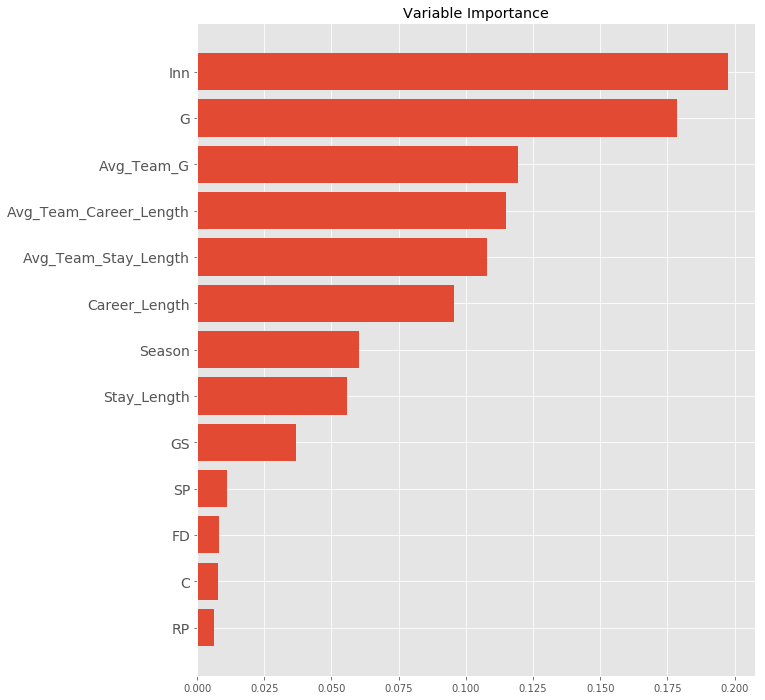

In [42]:
ind = np.argsort(rf.feature_importances_)
plt.figure(figsize=(10,12))

plt.barh(range(len(rf.feature_importances_)),rf.feature_importances_[ind])
# It is very important that you use the same columns that you fit your model with, or else this will be wrong!
plt.yticks(range(len(rf.feature_importances_)), X_train.columns[ind], fontsize=14)
plt.title("Variable Importance")
plt.show()

## Extra Trees

In [43]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

et = ExtraTreesClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [9, 4, 6],
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 2, 5], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [5, 1,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
#grid_obj = GridSearchCV(et, parameters, n_jobs=4)#, scoring=acc_scorer)
#grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
#et = grid_obj.best_estimator_


et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [44]:
accuracy_score(y_test, et.predict(X_test))

0.65611814345991559

In [ ]:
et.predict(X_test)

In [ ]:
ind = np.argsort(et.feature_importances_)
plt.figure(figsize=(10,12))

plt.barh(range(len(et.feature_importances_)),et.feature_importances_[ind])
# It is very important that you use the same columns that you fit your model with, or else this will be wrong!
plt.yticks(range(len(et.feature_importances_)),X_train.columns[ind])
plt.title("Variable Importance")
plt.show()

## Adaboost

In [45]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

ab = AdaBoostClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [9, 4, 6],
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 2, 3, 5], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [5, 1,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
#grid_obj = GridSearchCV(ab, parameters, n_jobs=4)#, scoring=acc_scorer)
#grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
#ab = grid_obj.best_estimator_


ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [46]:
accuracy_score(y_test, ab.predict(X_test))

0.7067510548523207

In [ ]:
ab.predict(X_test)

## Logistic Regression

In [ ]:
logreg = LogisticRegressionCV()
logreg.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, logreg.predict(X_test))

## SVM

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, clf.predict(X_test))

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, model.predict(X_test))

In [ ]:
pd.concat([X, y], axis=1).to_csv('perfect_numeric_data.csv')

## XGBoost

In [47]:
import xgboost as xgb

In [48]:
xmodel = xgb.XGBClassifier()
xmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
accuracy_score(y_test, xmodel.predict(X_test))

0.70956399437412099